## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. In this project the results of an A/B test run by an e-commerce website will be analyzed. The end goal is to determine if the e-commerce should keep the old page, change to the new page or run the experiment for a longer time.

<a id='probability'></a>
#### Part I - Probability

First of all, the needed libraries are imported. 

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
# Read the dataset and print the first columns
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
# Number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
# Number of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
# Proportion of converted users
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# Number of times treatment and new_page don't match
df.query('group != "treatment" and landing_page == "new_page"').shape[0] + \
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
# Check the number of values from each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Create the new dataset by removing the columns that don't match
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [10]:
# Check the number of columns
df2.shape[0]

290585

In [11]:
# Double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
# Calculate the user_id unique values
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# Check there is actually one user_id repeated
sum(df2.user_id.duplicated())

1

In [14]:
# Find the repeted user_id
df2.loc[df2.user_id.duplicated(), 'user_id'].values[0]

773192

c. What is the row information for the repeat **user_id**? 

In [15]:
# Show the information about the repeated user_id
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
# Remove the duplicates of user_id
df2 = df2.drop_duplicates(['user_id'])

# Check number of columns
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# Calculate the probability of an individual converting
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# Calculate the probability of an individual of the control group converting
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# Calculate the probability of an individual of the treatment group converting
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
# Calculate the probability of an individual receiving the new page
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**The difference in individuals from each group that converted is quite small (0.1204 - 0.1188 = 0.0016). The sample size is big, which makes it representative of the population. These could indicate that the new page did not lead to a higher number of converted users. However, more analysis should be done in order to conclude if the old page lead to more or less converted users than the new page. An example could be a hyphothesis test, where the statistical differences should be significant to actually conclude that one page is better than the other.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**In this case the null hypothesis will be $p_{old}$ - $p_{new}$ >= 0 and the alternative hypothesis $p_{old}$ - $p_{new}$ < 0.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
# Conversion rate for Pnew
cr_new = df2.converted.mean()
cr_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
# Conversion rate for Pold
cr_old = df2.converted.mean()
cr_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
# Number of users in the treatment group
n_new = df2.query('group == "treatment"').user_id.nunique()
n_new

145310

d. What is $n_{old}$?

In [24]:
# Number of users in the control group
n_old = df2.query('group == "control"').user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
# Simulate the transaction for Pnew
new_page_converted = np.random.choice([0, 1], size = n_new, p = [cr_new, 1 - cr_new])
new_page_converted.mean()

0.8806964420893263

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
# Simulate the transaction for Pold
old_page_converted = np.random.choice([0, 1], size = n_old, p = [cr_old, 1 - cr_old])
old_page_converted.mean()

0.8796618803089334

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
# Calculate the difference between Pnew and Pold
obs = new_page_converted.mean() - old_page_converted.mean()
obs

0.0010345617803928508

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
# Create a sampling distribution by using the bootstrapping method
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [cr_new, 1 - cr_new])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [cr_old, 1 - cr_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

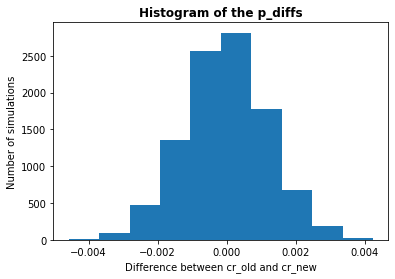

In [29]:
# Convert p_diffs into an array
p_diffs = np.array(p_diffs)

# Plot the histogram
plt.hist(p_diffs)
plt.title('Histogram of the p_diffs', weight='bold')
plt.xlabel('Difference between cr_old and cr_new')
plt.ylabel('Number of simulations');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# Calculate the actual difference
a_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
a_diffs

-0.0015782389853555567

In [31]:
# Calculate the difference between the actual and the simulated
(p_diffs > a_diffs).mean()

0.9022

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated in part j is the p-value, which indicates the probability of accepting or refusing our null hypothesis. In this case, the p-value is close to 1 and this means that the null hypotesis can't be rejected. Hence, the old page is better or equal than the old page referring to the number of users converted.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [34]:
# Calculate the critical value at 95% confidence interval
norm.ppf(1-0.05)

1.6448536269514722

**The z-value is lower than the 95% confidence interval, which indicates that the null hypothesis can't be rejected. The p-value indicates the same, like in the part j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**A logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Create a copy of the dataset
df3 = df2

# Create the column intercept
df3['intercept'] = 1

#Create dummy variables
df3[['control','ab_page']] = pd.get_dummies(df2.group)

# Drop column control
df3.drop('control', axis = 1, inplace = True)

# Show the head
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
# Create a logistic regression
logit  = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
# Show summary of the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        09:31:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value of the ab_page is 0.19, which differ from the value found in Part II because the null and alternative hypotheses are different. In this part the null hypothesis is $P_{old}$ - $P_{new}$ = 0 and the alternative hypotesis is $P_{old}$ - $P_{new}$ != 0.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more terms into the regression model can make the results of the model more accurate and reliable. An example could be to analyze the dates on which users converted, if it was at weekends or during the week, or include more information about the users like age, city, etc. However, when adding new factors it is important to consider the multicollinearity that can appear between factors, which could end up with misleading results. To avoid this the VIF can be calculated to determine the two (or more) variables that are correlated and drop one of them before repeating the analysis.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
# Read an open the dataset
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# Create and show the new dataset
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
# Show the possible values of the column country
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [41]:
# Create the necessary dummy variables considering 'CA' as the baseline category
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [42]:
# Create the logistic regression 
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])

# Show the results
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 10 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        09:31:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**The p-value of the countries if higher than 0.05, which indicates that the country does not show significant statistical differences in the conversion of users.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
# Create the interaction variables between page and UK/US
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']

# Visualize if the columns have been created correctly
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,ab_UK,ab_US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [44]:
# Create a logistic regression
logit = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_UK','ab_US']])

# Show the results
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 10 May 2020   Pseudo R-squ.:               1.082e-05
Time:                        09:31:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
ab_UK          0.0112      0.018      0.626      0.532      -0.024       0.046
ab_US         -0.0144      0.012     -1.155      0.248      -0.039       0.010
==============================================================================
"""

**The p-value in both cases is higher than 0.05, which indicate that there is no statistical significance differences between the countries and page on conversion.**

<a id='conclusions'></a>
## Conclusions

Looking at the results of each part, it can be concluded that the old page lead to more converted users than the new page. 
- Part I: the probability test showed very small difference between both pages of 0.16%.
- Part II: the p-value of the A/B test had a value of 0.9, which indicates that the null hypothesis ( $p_{new}$ - $p_{old}$ >= 0) can't be rejected. 
- Part III: the logistic regressions showed p-values higher than 0.05, which indicate that $p_{new}$ and $p_{old}$ were not the same and that the country of the users did not influence significantly the results. 